# 逻辑回归

### 杜小勤，武汉纺织大学数学与计算机学院，2020年03月01日
https://github.com/duxiaoqin/Lecture-notes-for-Machine-Learning

二分类逻辑回归分类器的实现

In [1]:
import numpy as np

In [2]:
class BinLogisticRegression:
    def __init__(self, max_step = 80, learning_rate = 0.01):
        self.max_step = max_step
        self.learning_rate = learning_rate
        
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    #可用训练方案：批训练、mini-batch训练与随机梯度下降训练
    def fit(self, X, Y):
        self.weights = np.zeros((1, len(X[0])), dtype = np.float32)
        
        self.paras = [] #存放中间权值的结果，用于生成动画
        for step in range(self.max_step):
            results = self.sigmoid(np.dot(X, np.transpose(self.weights)))
            self.weights = self.weights + np.sum(self.learning_rate * (Y - results) * X, axis = 0)
            self.paras.append(self.weights)
        print('Weights:', self.weights)
        print('Binomial logistic regression model training completed!')
    
    #直接利用对数几率（logit）函数进行预测：wx>=0，1；否则，0
    def predict(self, X):
        return [[1] if z >= 0 else [0] for z in np.dot(X, np.transpose(self.weights))]

载入预存的鸢尾花数据集

In [3]:
iris_npz = np.load('iris.npz')
data = iris_npz['data']
X = iris_npz['X']
Y = iris_npz['Y']

数据集预处理

In [4]:
from sklearn.model_selection import train_test_split

X = np.insert(X, 0, values = 1, axis = 1) #将偏置并入权值中，其对应的x=1
Y = Y.reshape(-1, 1)

XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X, Y, test_size = 0.3)

使用鸢尾花数据集训练二分类逻辑回归模型

In [5]:
blr = BinLogisticRegression()
blr.fit(XTRAIN, YTRAIN)

Weights: [[-0.5860826   4.06423765 -6.89826648]]
Binomial logistic regression model training completed!


使用鸢尾花测试数据集进行测试

In [6]:
from collections import Counter

results = blr.predict(XTEST)
scores = (results == YTEST)
scores = [score[0] for score in scores]
print('Accuracy = {:3.2f}%'.format(Counter(scores)[True]/len(YTEST) * 100))

Accuracy = 96.67%


简单的预测测试

In [7]:
XSAMPLES = [(1, 5.5, 2.8), (1, 5.5, 3.5), (1, 4.5, 3.5), (1, 6.5, 2.5)]
results = blr.predict(XSAMPLES)
print(results)

[[1], [0], [0], [1]]


绘制数据集、决策面与测试样例

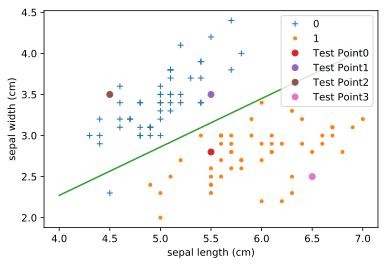

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')

#绘制决策面
x_ponits = np.arange(4, 8)
y_points = -(blr.weights[0][1] * x_ponits + blr.weights[0][0])/blr.weights[0][2]
plt.plot(x_ponits, y_points)

for i, point in enumerate(XSAMPLES):#绘制测试样例点
    plt.plot(point[1], point[2], 'o', label='Test Point{0}'.format(i))
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.savefig('LR_OUTPUT1.pdf', bbox_inches='tight')

绘制训练动画

<IPython.core.display.Javascript object>


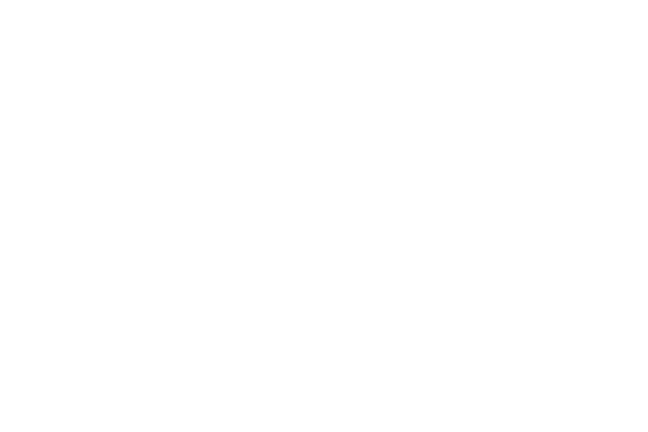

<IPython.core.display.Javascript object>


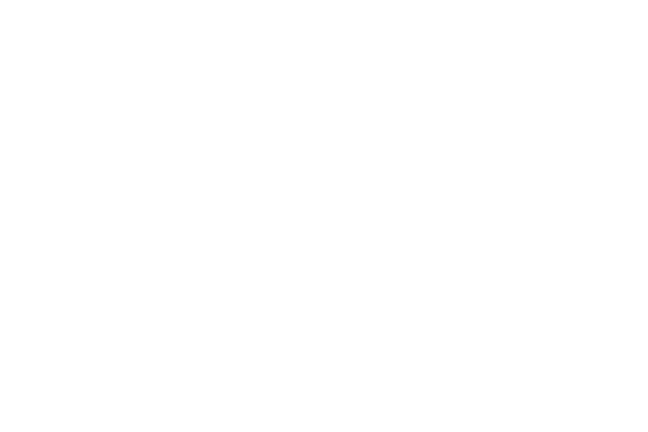

In [9]:
import matplotlib.animation as animation
from IPython.display import HTML
#动画播放，如果是%matplotlib inline，则会嵌入图片
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(xlim=(3, 7), ylim=(2, 5))

ax.plot(data[:50, 0], data[:50, 1], '+', label='0')
ax.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
ax.set_xlabel('sepal length (cm)')
ax.set_ylabel('sepal width (cm)')
ax.set_title('Logistic Regression')
ax.legend(loc = 'upper left')

line, = ax.plot([], [], lw = 2)
def update(para):
    b = para[0][0]
    W0 = para[0][1]
    W1 = para[0][2]
    
    X_points = np.linspace(4, 7,10)
    Y_points = -(W0 * X_points + b)/W1
    line.set_data(X_points, Y_points)
ani = animation.FuncAnimation(fig, update, blr.paras)
#视频播放
#安装FFMPEG库
#在anaconda环境下，需要执行“conda install -c conda-forge ffmpeg”
#需要FFMPEG.exe，直接下载BUILD，解压到目录，例如E:\ffmpeg\bin
#然后在环境变量PATH中添加“E:\ffmpeg\bin”，路径名称需要根据实际情况做相应的调整
HTML(ani.to_html5_video())

In [10]:
ani.save('Fitting-duxiaoqin.mp4')

多分类逻辑回归分类器的实现

In [11]:
class MulLogisticRegression:
    def __init__(self, max_step = 80, learning_rate = 0.01):
        self.max_step = max_step
        self.learning_rate = learning_rate
    
    #支持X为多样本情形（即矩阵形式）
    def softmax(self, X):
        Y = np.exp(np.dot(X, np.transpose(self.weights)))
        return Y / np.sum(Y, axis = 1).reshape(-1, 1)
    
    #可用训练方案：批训练、mini-batch训练与随机梯度下降训练
    def fit(self, X, Y):
        K = len(Y[0]) #Y:One-hot编码格式，K表示类别个数
        self.weights = np.zeros((K, len(X[0])), dtype = np.float32)
        
        for step in range(self.max_step):
            results = self.softmax(X)
            errors = Y - results
            for k in range(K): #配置K个权值向量（通常情况下，配置K-1个权值向量。可以证明2者理论上等价）
                #可以证明，多项逻辑回归与二项情形非常类似：每个类别的权值分量只与本类别的误差及X的相应分量有关
                self.weights[k] = self.weights[k] + np.sum(self.learning_rate * errors[:, k].reshape(-1, 1) * X, axis = 0)
        print('Weights:', self.weights)
        print('Multinomial logistic regression model training completed!')
    
    def predict(self, X):
        return np.argmax(self.softmax(X), axis = 1)

使用所有的鸢尾花数据集

In [12]:
iris_npz_full = np.load('iris_full.npz')
data_full = iris_npz_full['data']
XFULL = iris_npz_full['X']
YFULL = iris_npz_full['Y']

数据集预处理

In [13]:
from sklearn.preprocessing import OneHotEncoder

XFULL_POST = np.insert(XFULL, 0, values = 1, axis = 1) #将偏置并入权值中，其对应的x=1
YFULL_POST = YFULL.reshape(-1, 1)

encoder = OneHotEncoder()
encoder.fit(YFULL_POST)
YFULL_POST = encoder.transform(YFULL_POST).toarray()

XTRAINFULL, XTESTFULL, YTRAINFULL, YTESTFULL = train_test_split(XFULL_POST, YFULL_POST, test_size = 0.3)

使用所有的鸢尾花数据集训练多项逻辑回归模型

In [14]:
mlr = MulLogisticRegression(max_step = 280)
mlr.fit(XTRAINFULL, YTRAINFULL)

Weights: [[  1.39598751   3.13638735   6.89958143  -8.52016354  -4.02731323]
 [  2.73833251   4.59755087   0.27354085  -3.89949369  -4.9549365 ]
 [ -4.13431931  -7.73394251  -7.17312574  12.41965485   8.98224831]]
Multinomial logistic regression model training completed!


使用鸢尾花测试数据集进行测试

In [15]:
results = mlr.predict(XTESTFULL)
scores = (results == np.argmax(YTESTFULL, axis = 1))
print('Accuracy = {:3.2f}%'.format(Counter(scores)[True]/len(YTESTFULL) * 100))

Accuracy = 97.78%


sklearn.linear_model.LogisticRegression

该类中的solver参数定义了四种优化方法，它们分别是：
- liblinear：使用开源liblinear库的实现，内部使用坐标轴下降法来迭代优化损失函数；
- lbfgs：拟牛顿法的一种，利用近似海森矩阵来迭代优化损失函数；
- newton-cg：牛顿法的一种，利用海森矩阵来迭代优化损失函数；
- sag：随机平均梯度下降，梯度下降法的变种。与普通梯度下降法的区别在于，每次迭代仅仅用一部分的样本来计算梯度，适用于样本数据较多的情形；

In [16]:
from sklearn.linear_model import LogisticRegression

使用鸢尾花的二分类数据进行训练与测试

In [17]:
clf = LogisticRegression(max_iter = 200)
clf.fit(XTRAIN[:, 1:], YTRAIN.reshape(-1)) #去掉XTRAIN中附加的1（第0列）

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
clf.score(XTEST[:, 1:], YTEST.reshape(-1))

0.96666666666666667

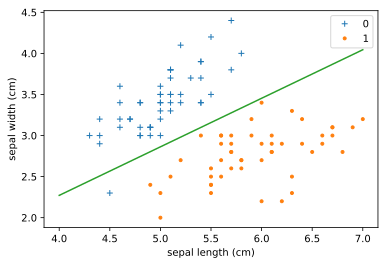

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')

#绘制决策面
x_ponits = np.arange(4, 8)
y_points = -(clf.coef_[0][0]*x_ponits + clf.intercept_)/clf.coef_[0][1]
plt.plot(x_ponits, y_points)

plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()
plt.savefig('LR_OUTPUT2.pdf', bbox_inches='tight')

使用鸢尾花的多分类数据进行训练与测试

In [20]:
clf = LogisticRegression(max_iter = 200)
clf.fit(XTRAINFULL[:, 1:], np.argmax(YTRAINFULL, axis = 1)) #去掉XTRAIN中附加的1（第0列）

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
clf.score(XTESTFULL[:, 1:], np.argmax(YTESTFULL, axis = 1))

0.97777777777777775

参考文献：

- https://github.com/wzyonggege/statistical-learning-method
- 李航。《统计学习方法》，清华大学出版社，2012年3月第1版；